<h3>Подключение необходимых библиотек и модулей</h3>

In [ ]:
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from evaluation import evaluate_classification, plot_confusion_matrix
from processing import text_preprocessing

<h3>Загрузка данных из Parquet</h3>

In [2]:
df = pd.read_parquet("train-00000-of-00001.parquet")
df

,title,text,topic,labels
0,"Два немца стали кандидатами в тренеры ""Динамо""",Два немецких футбольных тренера стали кандидат...,Спорт,1
1,Россия добавит тяги китайским истребителям,"Российские турбореактивные двигатели РД-93, пр...",Наука и техника,2
2,«Газпром» пересмотрел планы по строительству «...,«Газпром» сократил протяженность участка газоп...,Бизнес,4
3,"Российские зрители не услышат, как поет Ричард...",\nНа экраны российских кинотеатров выходит оди...,Культура,3
4,Призовой фонд Australian Open-2013 достиг реко...,Организаторы Открытого чемпионата Австралии по...,Спорт,1
...,...,...,...,...
185967,Суд отказался рассматривать иск по тарифам МПС,Арбитражный суд Москвы не принял к рассмотрени...,Экономика,0
185968,Мнение Михалкова о Ельцин-центре испортилось п...,"Режиссер Никита Михалков выразил сожаление, чт...",Культура,3
185969,"Российские страховщики увеличили активы до 1,6...",Активы российских страховщиков в 2015 году выр...,Экономика,0
185970,Украина введет ответное продэмбарго против России,"Премьер-министр Украины Арсений Яценюк заявил,...",Экономика,0


<h3>Проверка на пропуски</h3>

In [3]:
df.isnull().sum()

title     0
text      0
topic     0
labels    0
dtype: int64

<h3>Преобразование текстов</h3>

In [4]:
df["title_preprocessed"] = text_preprocessing(df["title"])

c:\ProgramData\anaconda3\envs\nlp_task\Lib\site-packages\pymorphy3\analyzer.py:114: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
X = df["title_preprocessed"]
y = df["topic"].astype("category")
X

0                        немец стать кандидат тренер динамо
1                россия добавить тяга китайский истребитель
2         газпром пересмотреть план строительство сила с...
3               российский зритель услышать петь ричард гир
4         призовой фонд australian open достигнуть рекор...
                                ...                        
185967           суд отказаться рассматривать иск тариф мпс
185968    мнение михалков ельцин центр испортиться посещ...
185969    российский страховщик увеличить актив триллион...
185970    украина ввести ответный продэмбарго против россия
185971          путин увидеть биткоина потенциальный угроза
Name: title_preprocessed, Length: 185972, dtype: object

<h3>Разбиение выборки на тренировочную, валидационную и тестовую</h3>

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, stratify=y, shuffle=True, test_size=0.2, random_state=1
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    stratify=y_temp,
    shuffle=True,
    test_size=0.5,
    random_state=1,
)

<h3>Обучение базовой модели: Bag of Words на униграммах (Заголовки новостей) + Balanced Logistic Regression</h3>

In [ ]:
nlp_pipeline = Pipeline(
    [
        (
            "feature_extraction",
            CountVectorizer(
                lowercase=False,
                token_pattern=None,
                tokenizer=lambda token: word_tokenize(token, language="russian"),
                dtype=np.float32,
            ),
        ),
        (
            "model",
            LogisticRegression(class_weight="balanced", random_state=1, max_iter=200),
        ),
    ]
)
nlp_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feature_extraction', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",False
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",<function <la...00288CBC99580>


<h3>Оценка модели на тренировочной выборке</h3>

In [6]:
y_pred_train = nlp_pipeline.predict(X_train)
evaluate_classification(y_train, y_pred_train)

                 precision    recall  f1-score   support

         Бизнес      0.515     0.971     0.673      4274
       Культура      0.975     0.983     0.979     31044
Наука и техника      0.965     0.968     0.967     30521
          Спорт      0.993     0.990     0.991     37147
      Экономика      0.981     0.895     0.936     45791

       accuracy                          0.954    148777
      macro avg      0.886     0.961     0.909    148777
   weighted avg      0.966     0.954     0.958    148777

MCC равен 0.941


<h3>Неплохие показатели за исключением категории Бизнес.</h3>

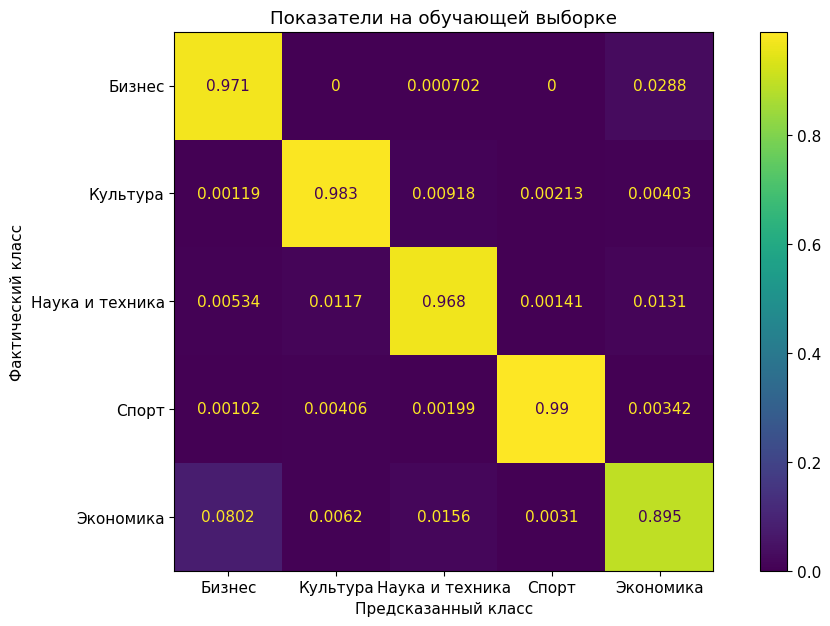

In [7]:
plot_confusion_matrix(
    nlp_pipeline,
    X_train,
    y_train,
    title="Показатели на обучающей выборке",
    font_size=11,
)

<h3>Оценка модели на валидационной выборке</h3>

In [8]:
y_pred_val = nlp_pipeline.predict(X_val)
evaluate_classification(y_val, y_pred_val)

                 precision    recall  f1-score   support

         Бизнес      0.349     0.665     0.458       535
       Культура      0.937     0.947     0.942      3880
Наука и техника      0.916     0.926     0.921      3815
          Спорт      0.985     0.967     0.976      4643
      Экономика      0.931     0.852     0.889      5724

       accuracy                          0.910     18597
      macro avg      0.823     0.871     0.837     18597
   weighted avg      0.926     0.910     0.916     18597

MCC равен 0.883


<h3>Есть основания полагать что модель переобучилась. Проблема Bag of Words в отсутствии устойчивости к новизне: токены, которых не было во время обучения, будут проигнорированы моделью.</h3>

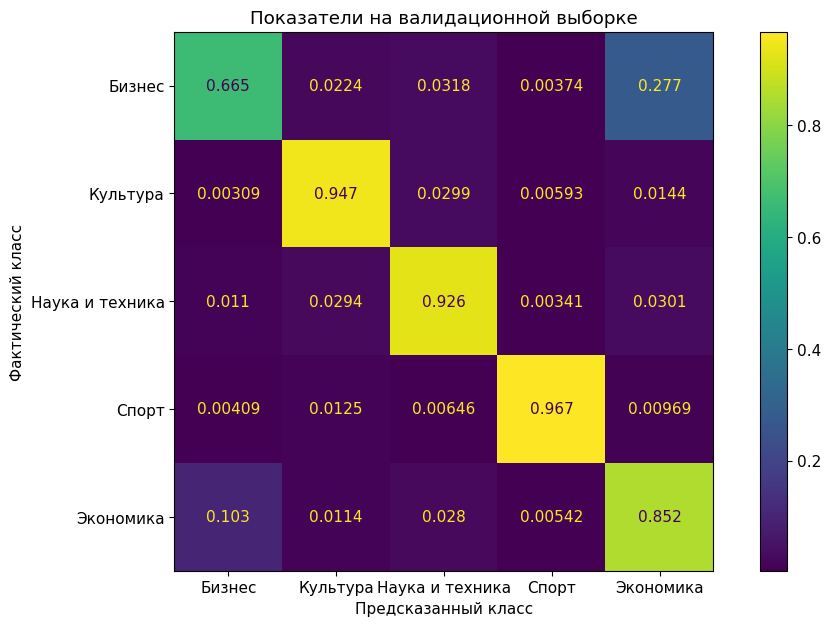

In [9]:
plot_confusion_matrix(
    nlp_pipeline,
    X_val,
    y_val,
    title="Показатели на валидационной выборке",
    font_size=11,
)

<h3>Основной проблемой является категории Бизнес и Экономика. В 2 из 3 случаев модель правильно классифицирует Бизнес категорию, в основном путая ее с Экономикой.</h3>